# TP n°3: Identification des paramètres du modèle de fermentation

## Objectif

On identifiera les paramètres du modèle en deux étapes:

1. [Identification des paramètres de rendement](#identif1) $k_1$ et $k_2$ en tirant profit des relations linéaires entre $N$ et $X$ et entre $E$ et $S$.

2. [Identification des autres paramètres](#identif2) en utilisant un algorithme de minimisation non linéaire

In [1]:
import numpy as np # module numpy: vecteur, matrices, instructions vectorisees
#import scipy as sc # module scipy: librairies scientifiques
import matplotlib.pyplot as plt # module matplotlib: librairie graphique
import scipy.integrate as scint
import scipy.optimize as scop
import os

plt.close('all') # close all figure

## <a name='identif1'>1. Identification des paramètres de rendement $k_1$ et $k_2$</a>

Le modèle de fermentation en réacteur batch suppose des relations linéaires entre $N$ et $X$ et entre $E$ et $S$.

On a en effet:
$$\frac{dS}{dt}+k_2\frac{dE}{dt}=0 \Longleftrightarrow S(t)+k_2E(t)=S(0)+k_2E(0)= \text{constante}$$
$$\frac{dN}{dt}+k_1\frac{dX}{dt}=0 \Longleftrightarrow N(t)+k_1X(t)=N(0)+k_1X(0)=\text{constante}$$

Cela veut dire que le modèle suppose que tout le sucre qui se dégrade se transforme en ethanol et que tout l'azote qui est consommée se transforme en biomasse.

Les relations étant linéaires, on peut utiliser un estimateur de moindres carrés linéaires.

$\bullet$ **Tracé de $N$ en fonction de $B$ et de $S$ en fonction de $E$** pour vérifier si on retrouve la relation linéaire dans les données

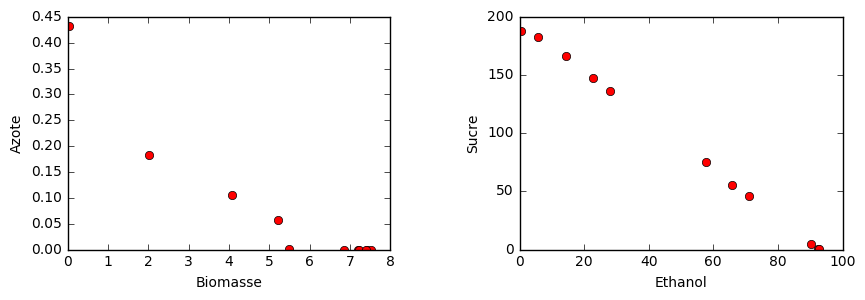

In [2]:
# Tracé des données expérimentales
# --------------------------------
    
# Chargement des données expérimentales qui sont stockées dans le fichier batch.txt
Data = np.loadtxt('batch.txt')
Datatime = Data[:,0] #temps
DataB2 = Data[:,1] # biomasse en 10^6 cell/mL
DataB = Data[:,6] # biomasse en g/L
DataN = Data[:,2]/1000 # azote
DataE = Data[:,3] # ethanol
DataS = Data[:,4] # sucre
DataCO2 = Data[:,5]/100 # taux de production de CO2

t0 = Datatime[0]  # instant initial de la simulation
tf = Datatime[-1] # instant final de la simulation

plt.figure(figsize = (10, 3))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.subplot2grid((1,2),(0,0))
plt.plot(DataB,DataN,'ro')
plt.xlabel('Biomasse')
plt.ylabel('Azote')

plt.subplot2grid((1,2),(0,1))
plt.plot(DataE,DataS,'ro')
plt.xlabel('Ethanol')
plt.ylabel('Sucre')

plt.show()

On constate effectivement une relation linéaire marquée entre $S$ et $E$. Entre $N$ et $B$ la linéarité est moins évidente.

$\bullet$ **Identification de $k_1$ et $k_2$** en résolvant les problèmes de minimisation suivants:
$$ (\hat{k_1},\hat{c_1})=\min_{(k_1,b)} \left\| k_1X(t)+c_1+N(t)\right\|^2 $$
$$ (\hat{k_2},\hat{c_2})=\min_{(k_2,c)} \left\| k_2E(t)+c_2+S(t)\right\|^2 $$

$\hat{k_1}$ et $\hat{k_2}$ sont des estimations de $k_1$ et de $k_2$.
$\hat{c_1}$ et $\hat{c_2}$ sont des estimations de $-N(0)-k_1X(0)$ et $-S(0)-k_2E(0)$.

On utilisera pour résoudre ces problèmes des fonctions déjà codés sous python comme la fonction np.linalg.lstsq qui calcule l'estimateur de moindre carrés pour un système linéaire $Ax=b$. Cette fonction permet donc de résoudre le problème
$$ \min_{x} \left\|Ax-b\right\|^2$$

estimation de k1= 0.050069879584
estimation de k2= 2.08478746168


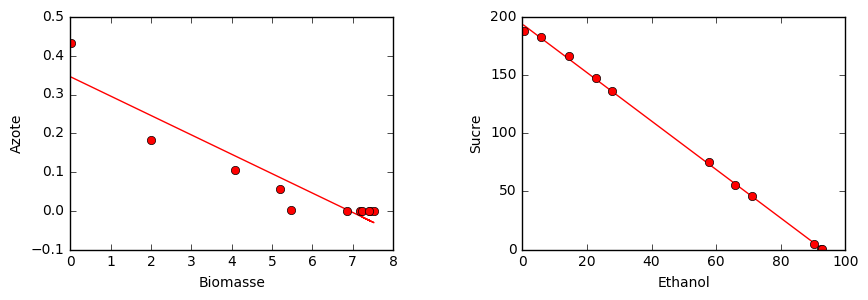

In [3]:
# Identification des paramètres k1 et k2 du modèle de fermentation en réacteur batch
# ----------------------------------------------------------------------------------

# identification de k1
# --------------------
A = np.vstack([DataB, np.ones(len(DataB))]).T
b = -DataN
k1_est, c1_est  = np.linalg.lstsq(A, b)[0]
print('estimation de k1=',k1_est)

plt.figure(figsize = (10, 3))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.subplot2grid((1,2),(0,0))
plt.plot(DataB,-k1_est*DataB-c1_est,'r')
plt.plot(DataB,DataN,'ro')
plt.xlabel('Biomasse')
plt.ylabel('Azote')

# identification de k2
# --------------------
A = np.vstack([DataE, np.ones(len(DataE))]).T
b = -DataS
k2_est, c2_est  = np.linalg.lstsq(A, b)[0]
print('estimation de k2=',k2_est)

plt.subplot2grid((1,2),(0,1))
plt.plot(DataE,-k2_est*DataE-c2_est,'r')
plt.plot(DataE,DataS,'ro')
plt.xlabel('Ethanol')
plt.ylabel('Sucre')

plt.show()

## <a name='identif2'>2. Identification des autres paramètres du modèle avec les moindres carrés</a>

Pour cela, on va résoudre le problème non linéaire suivant:

$$ \hat{\theta}=\min_{\theta} \left\|y^{sim}(\theta)-y^{data} \right\|^2$$

où $\theta$ est le vecteur des paramètres du modèle

$y^{sim}$ est la sortie simulée via le modèle

et $y^{data}$ est la sortie mesurée (données expérimentales)

Dans le cas de la fermentation, on a $4$ variables d'état donc le problème va s'écrire:

$$ \hat{\theta}=\min_{\theta} \left( \beta_E\left\|E^{sim}(\theta)-E^{data} \right\|^2 + \beta_S\left\|S^{sim}(\theta)-S^{data} \right\|^2 + \beta_N\left\|N^{sim}(\theta)-N^{data} \right\|^2 + \beta_X\left\|X^{sim}(\theta)-X^{data} \right\|^2\right)$$

où $\theta$ est le vecteur des paramètres du modèle de fermentation en réacteur batch

$(X^{sim},N^{sim},E^{sim},S^{sim})$ sont les sorties simulées via le modèle de fermentation en réacteur batch

$(X^{data},N^{data},E^{data},S^{data})$ sont les sorties mesurées (données expérimentales)

et $(\beta_X, \beta_N, \beta_E, \beta_S)$ sont des poids de pondération

A noter que, comme $E^{sim}$ est une trajectoire, c'est à dire une fonction du temps, la norme $\left\|E^{sim}-E^{data} \right\|^2$ est définie de la manière suivante:

$$\left\|E^{sim}(\theta)-E^{data} \right\|^2=\int_{0}^T (E^{sim}(\theta,s)-E^{data}(s))^2 ds$$

Numériquement, il va falloir calculer une approximation de cette intégrale car les mesures expérimentales sont discrètes. On ne mesure en effet pas les variables à chaque temps $t$ mais à des instants discrets $t_i$, $i=1:N$ où $N$ est le nombre de mesures effectuées.

On pourra par exemple utiliser l'approximation de type trapèze:

$$\left\|g \right\|^2=\int_{0}^T g(s)^2 ds \simeq \sum_{i=1}^{N-1} \frac{g(t_i)^2+g(t_{i+1})^2}{2}(t_{i+1}-t_i)$$

Les poids de pondération $\beta_E$ pourra quant à lui être calculé de la manière suivante:

$$ \beta_E = \frac{1}{\left\| E^{data} \right\|} = \frac{1}{\int_{0}^T (E^{data}(s))^2 ds}$$

que l'on pourra approcher numériquement par:

$$ \beta_E  \simeq \frac{1}{\sum_{i=1}^{N-1} \frac{E^{data}(t_i)^2+E^{data}(t_{i+1})^2}{2}(t_{i+1}-t_i)}$$


 final_simplex: (array([[  3.18908790e-02,   2.37380113e+00,   2.00086960e-01,
          2.65706323e+01,   2.09611775e-02,   4.60175653e-01,
         -4.50020119e-02,   7.93114553e-02,   2.23114072e-01,
         -3.99293911e+00,   2.06738928e+02],
       [  3.18908687e-02,   2.37380074e+00,   2.00087009e-01,
          2.65705933e+01,   2.09611717e-02,   4.60176274e-01,
         -4.50019302e-02,   7.93113769e-02,   2.23114016e-01,
         -3.99293128e+00,   2.06738915e+02],
       [  3.18908835e-02,   2.37380123e+00,   2.00086962e-01,
          2.65706437e+01,   2.09611878e-02,   4.60175369e-01,
         -4.50020366e-02,   7.93114753e-02,   2.23114094e-01,
         -3.99294142e+00,   2.06738928e+02],
       [  3.18908723e-02,   2.37380128e+00,   2.00086839e-01,
          2.65706738e+01,   2.09611356e-02,   4.60174824e-01,
         -4.50020805e-02,   7.93115799e-02,   2.23114020e-01,
         -3.99294719e+00,   2.06738908e+02],
       [  3.18908827e-02,   2.37380118e+00,   2.00087094e-0

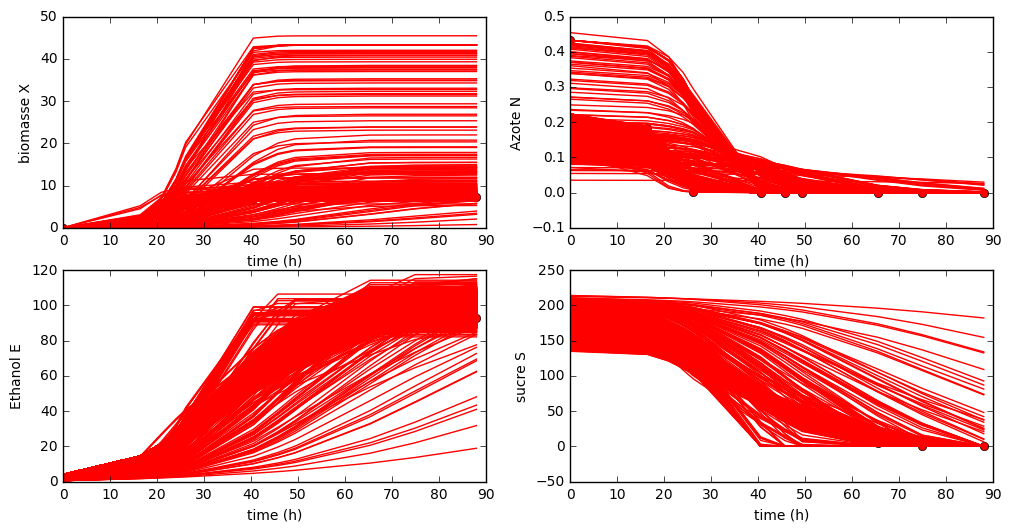

k1 = 0.0318908790307
k2 = 2.37380112964
mu1max = 0.200086960371
mu2max = 26.5706322766
KN = 0.0209611775145
KE = 0.460175652572
KS = 0.0450020119072
B0 = 0.0793114553449
N0 = 0.223114071873
E0 = 3.99293910561
S0 = 206.738928063


In [4]:
# modèle de fermentation en réacteur batch
def fermenteur(x,t,k1,k2,mu1max,mu2max,KN,KE,KS):
    # variables d'état du systèeme
    B = x[0] # biomasse
    N = x[1] # azote
    E = x[2] # ethanol
    S = x[3] # sucre
    
    # initialisation du vecteur second membre du système
    dx = np.zeros(4) # dérivées de B, N, E et S
    
    # calcul de mu1(S)
    mu1 = mu1max*N/(KN+N)
    # calcul de mu2(E,S)
    mu2 = mu2max*S/(KS+S)*KE/(KE+E)
    
    # second membre de l'équation de B
    dx[0] = mu1*B
    # second membre de l'équation de N
    dx[1] = -k1*mu1*B
    # second membre de l'équation de E
    dx[2] = mu2*B
    # second membre de l'équation de S
    dx[3] = -k2*mu2*B
    return dx

# Fonction à minimiser
def err(p,color_plot,cas,k2_est,beta):
    
    # p: paramètres du modèle à identifier
    # on rajoute des valeurs absolues pour être sûrs d'obtenir des paramètres à valeur positive
    if cas == 1: # CAS 1: on identifie tous les paramètres du modèle + la condition initiale
        k1 = abs(p[0])
        k2 = abs(p[1])
        mu1max = abs(p[2])
        mu2max = abs(p[3])
        KN = abs(p[4])
        KE = abs(p[5])
        KS = abs(p[6])
        # initial conditions
        x0 = abs(p[7:])
    elif cas == 2: # CAS 1: on identifie tous les paramètres du modèle sauf k2 + la condition initiale
        k1 = abs(p[0])
        k2 = k2_est
        mu1max = abs(p[1])
        mu2max = abs(p[2])
        KN = abs(p[3])
        KE = abs(p[4])
        KS = abs(p[5])
        # initial conditions
        x0 = abs(p[6:])

    # vecteur temps
    t = Datatime

    # intégration numérique du modèle de fermentation
    y = scint.odeint(fermenteur,x0,t,args=(k1,k2,mu1max,mu2max,KN,KE,KS))
    
    # tracé des sorties simulées 
    ax[0,0].plot(t,y[:,0],color=color_plot)
    ax[0,1].plot(t,y[:,1],color=color_plot)
    ax[1,0].plot(t,y[:,2],color=color_plot)
    ax[1,1].plot(t,y[:,3],color=color_plot)
    
    # Calcul de la valeur de la fonction coût
    f2min=np.zeros(4)
    # biomasse
    ftemp1 = (y[:,0]-DataB)**2
    f2min[0] = beta[0]*sum((Datatime[2:]-Datatime[1:-1])*(ftemp1[2:]+ftemp1[1:-1])/2)
   
    # Azote
    ftemp1 = (y[:,1]-DataN)**2 
    f2min[1] = beta[1]*sum((Datatime[2:]-Datatime[1:-1])*(ftemp1[2:]+ftemp1[1:-1])/2)
    
    # Ethanol
    ftemp1 = (y[:,2]-DataE)**2
    f2min[2] = beta[2]*sum((Datatime[2:]-Datatime[1:-1])*(ftemp1[2:]+ftemp1[1:-1])/2)
    
    # Sugcre
    ftemp1 = (y[:,3]-DataS)**2
    f2min[3] = beta[3]*sum((Datatime[2:]-Datatime[1:-1])*(ftemp1[2:]+ftemp1[1:-1])/2)
    
    f2min = sum(f2min)
    
    return f2min

    
# Identification du modèle de fermentation
# ----------------------------------------
# Identification 1: on identifie tous les paramètres et la condition initiale
# ---------------------------------------------------------------------------

# tracé des données
f, ax = plt.subplots(2,2,figsize = (12, 6))
ax[0,0].plot(Datatime,DataB,'ro')
ax[0,0].set_xlabel('time (h)')
ax[0,0].set_ylabel('biomasse X')
ax[0,1].plot(Datatime,DataN,'ro')
ax[0,1].set_xlabel('time (h)')
ax[0,1].set_ylabel('Azote N')
ax[1,0].plot(Datatime,DataE,'ro')
ax[1,0].set_xlabel('time (h)')
ax[1,0].set_ylabel('Ethanol E')
ax[1,1].plot(Datatime,DataS,'ro')
ax[1,1].set_xlabel('time (h)')
ax[1,1].set_ylabel('sucre S')

# Calcul des poids de pondération
beta=np.zeros(4)
ftemp2 = DataB**2 
beta[0]= 1/sum((Datatime[2:]-Datatime[1:-1])*(ftemp2[2:]+ftemp2[1:-1])/2)
ftemp2 = DataN**2
beta[1]= 1/sum((Datatime[2:]-Datatime[1:-1])*(ftemp2[2:]+ftemp2[1:-1])/2)
ftemp2 = DataE**2
beta[2]= 1/sum((Datatime[2:]-Datatime[1:-1])*(ftemp2[2:]+ftemp2[1:-1])/2)
ftemp2 = DataS**2
beta[3]= 1/sum((Datatime[2:]-Datatime[1:-1])*(ftemp2[2:]+ftemp2[1:-1])/2)

# valeurs initiales des paramètres du modèle
k1 = 0.01 # -
k2 = 2.0 # -
mu1max = 1.2 # 1/h
mu2max = 1.2 # 1/h
KN = 1.6 # g/L
KE = 12. # g/L
KS = 0.03 # g/L
p0 = np.array([k1,k2,mu1max,mu2max,KN,KE,KS,DataB[0],DataN[0],DataE[0],DataS[0]])

color_plot='r'
cas = 1 # on identifie tous les paramètres du modèle plus la condition initiale
# Remarque: attention, si un seul argument dans la fonction à minimiser, par exemple color_plot,
# alors il faut mettre args=(color_plot,) avec une virgule avant la parenthese pour dire que c'est 
# un tuple ...
ps1 = scop.minimize(err,p0,args=(color_plot,cas,k2_est,beta),method='Nelder-Mead',options={"maxiter":40000})
print(ps1)
plt.show()

print('k1 =',abs(ps1.x[0]))
print('k2 =',abs(ps1.x[1]))
print('mu1max =',abs(ps1.x[2]))
print('mu2max =',abs(ps1.x[3]))
print('KN =',abs(ps1.x[4]))
print('KE =',abs(ps1.x[5]))
print('KS =',abs(ps1.x[6]))
print('B0 =',abs(ps1.x[7]))
print('N0 =',abs(ps1.x[8]))
print('E0 =',abs(ps1.x[9]))
print('S0 =',abs(ps1.x[10]))

 final_simplex: (array([[  3.22020282e-02,   2.12054426e-01,   8.99923187e-01,
          2.75522834e-02,   2.06005919e+01,   3.19064608e-02,
          7.24544346e-02,   2.25487956e-01,   2.62831268e-01,
          1.92175434e+02],
       [  3.22020363e-02,   2.12054763e-01,   8.99925572e-01,
          2.75524613e-02,   2.06005277e+01,   3.19064528e-02,
          7.24542018e-02,   2.25488001e-01,   2.62834225e-01,
          1.92175477e+02],
       [  3.22020592e-02,   2.12054509e-01,   8.99921779e-01,
          2.75524195e-02,   2.06006512e+01,   3.19064048e-02,
          7.24545466e-02,   2.25488171e-01,   2.62827633e-01,
          1.92175501e+02],
       [  3.22020232e-02,   2.12054511e-01,   8.99924254e-01,
          2.75523249e-02,   2.06005803e+01,   3.19064572e-02,
          7.24543729e-02,   2.25487934e-01,   2.62832051e-01,
          1.92175492e+02],
       [  3.22020431e-02,   2.12054397e-01,   8.99920920e-01,
          2.75523739e-02,   2.06006700e+01,   3.19064252e-02,
       

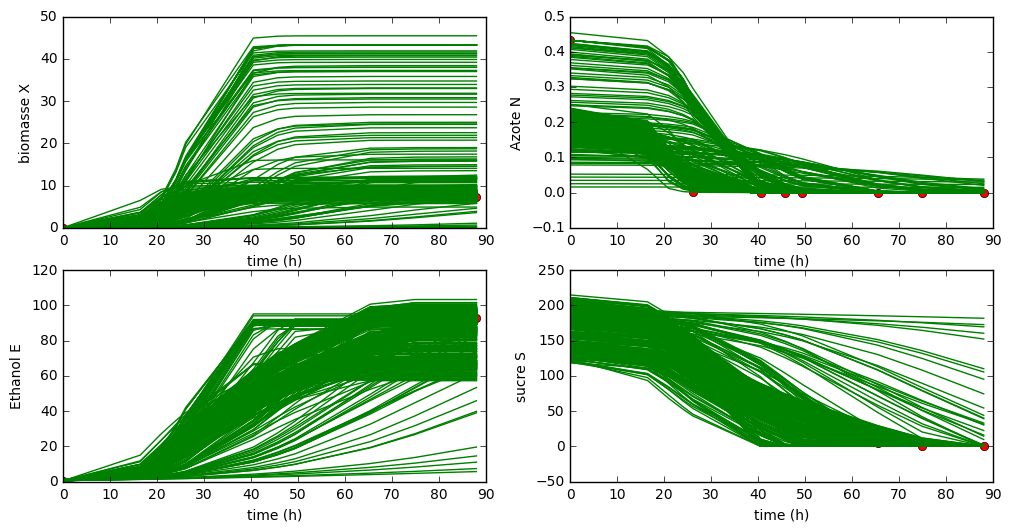

k1 = 0.0322020281695
mu1max = 0.212054425944
mu2max = 0.899923187196
KN = 0.027552283403
KE = 20.6005919034
KS = 0.0319064608047
B0 = 0.0724544345982
N0 = 0.225487955665
E0 = 0.262831267853
S0 = 192.175433654


In [5]:
# Identification 2: on identifie la condition initiale ettous les paramètres sauf k2 qui prend la valeur k2_est 
# -------------------------------------------------------------------------------------------------------------
# tracé des données
f, ax = plt.subplots(2,2,figsize = (12, 6))
ax[0,0].plot(Datatime,DataB,'ro')
ax[0,0].set_xlabel('time (h)')
ax[0,0].set_ylabel('biomasse X')
ax[0,1].plot(Datatime,DataN,'ro')
ax[0,1].set_xlabel('time (h)')
ax[0,1].set_ylabel('Azote N')
ax[1,0].plot(Datatime,DataE,'ro')
ax[1,0].set_xlabel('time (h)')
ax[1,0].set_ylabel('Ethanol E')
ax[1,1].plot(Datatime,DataS,'ro')
ax[1,1].set_xlabel('time (h)')
ax[1,1].set_ylabel('sucre S')

# valeurs initiales des paramètres du modèle
p0 = np.array([k1,mu1max,mu2max,KN,KE,KS,DataB[0],DataN[0],DataE[0],DataS[0]])

color_plot='g'
cas = 2 # on identifie tous les paramètres du modèle plus la condition initiale
# attention, si un seul argument, par exemple color_plot, alors il faut mettre
# args=(color_plot,) avec une virgule avant la parenthese pour dire que c'est 
# un tuple ...
ps2 = scop.minimize(err,p0,args=(color_plot,cas,k2_est,beta),method='Nelder-Mead',options={"maxiter":40000})
print(ps2)
plt.show()

print('k1 =',abs(ps2.x[0]))
print('mu1max =',abs(ps2.x[1]))
print('mu2max =',abs(ps2.x[2]))
print('KN =',abs(ps2.x[3]))
print('KE =',abs(ps2.x[4]))
print('KS =',abs(ps2.x[5]))
print('B0 =',abs(ps2.x[6]))
print('N0 =',abs(ps2.x[7]))
print('E0 =',abs(ps2.x[8]))
print('S0 =',abs(ps2.x[9]))


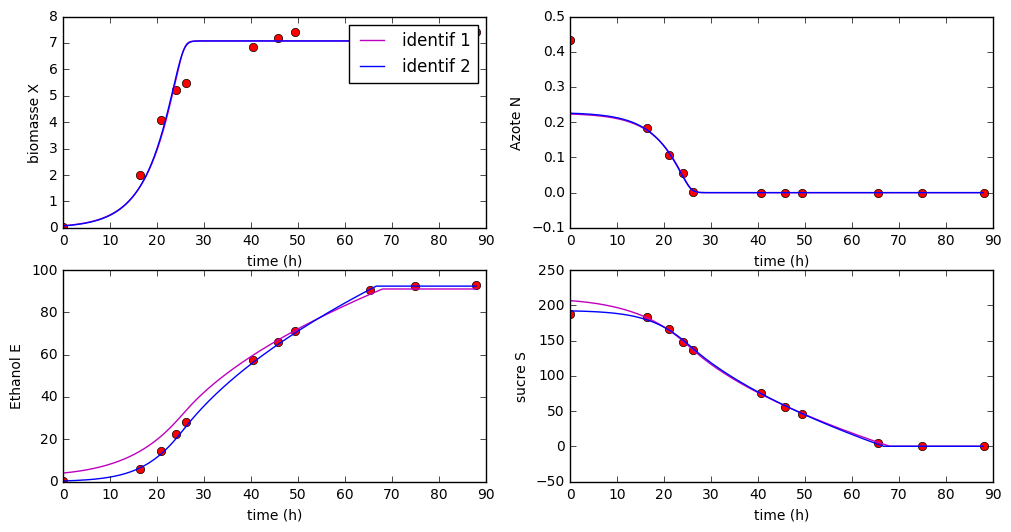

In [9]:
# Simulations avec les paramètres identifiés: comparaison entre les résultats des deux identifications
# ----------------------------------------------------------------------------------------------------
f2, ax2 = plt.subplots(2,2,figsize = (12, 6))
ax2[0,0].plot(Datatime,DataB,'ro')
ax2[0,0].set_xlabel('time (h)')
ax2[0,0].set_ylabel('biomasse X')
ax2[0,1].plot(Datatime,DataN,'ro')
ax2[0,1].set_xlabel('time (h)')
ax2[0,1].set_ylabel('Azote N')
ax2[1,0].plot(Datatime,DataE,'ro')
ax2[1,0].set_xlabel('time (h)')
ax2[1,0].set_ylabel('Ethanol E')
ax2[1,1].plot(Datatime,DataS,'ro')
ax2[1,1].set_xlabel('time (h)')
ax2[1,1].set_ylabel('sucre S')

# Simulation avec le premier jeu de paramètres identifiés
# -------------------------------------------------------
k1 = abs(ps1.x[0])
k2 = abs(ps1.x[1])
mu1max = abs(ps1.x[2])
mu2max = abs(ps1.x[3])
KN = abs(ps1.x[4])
KE = abs(ps1.x[5])
KS = abs(ps1.x[6])

# condition initiale
x0 = abs(ps1.x[7:])

# vecteur temps
t = np.arange(t0,tf,0.1)

# intégration numérique de l'EDO
y = scint.odeint(fermenteur,x0,t,args=(k1,k2,mu1max,mu2max,KN,KE,KS))

# tracé des solutions
color_plot='m'
ax2[0,0].plot(t,y[:,0],color=color_plot,label='identif 1')
ax2[0,1].plot(t,y[:,1],color=color_plot)
ax2[1,0].plot(t,y[:,2],color=color_plot) 
ax2[1,1].plot(t,y[:,3],color=color_plot)

# Simulation avec le deuxième jeu de paramètres identifiés
# -------------------------------------------------------
k1 = abs(ps2.x[0])
k2 = k2_est
mu1max = abs(ps2.x[1])
mu2max = abs(ps2.x[2])
KN = abs(ps2.x[3])
KE = abs(ps2.x[4])
KS = abs(ps2.x[5])

# condition initiale
x0 = abs(ps2.x[6:])

# integration numerique de l'EDO
y = scint.odeint(fermenteur,x0,t,args=(k1,k2,mu1max,mu2max,KN,KE,KS))

# tracé des solutions
color_plot='b'
ax2[0,0].plot(t,y[:,0],color=color_plot,label='identif 2')
ax2[0,1].plot(t,y[:,1],color=color_plot)
ax2[1,0].plot(t,y[:,2],color=color_plot) 
ax2[1,1].plot(t,y[:,3],color=color_plot)
ax2[0,0].legend()

plt.show()
    